In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gdsc-data-extra/gdsc_data_extra.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [3]:
gdsc_data = pd.read_csv('/kaggle/input/gdsc-data-extra/gdsc_data_extra.csv')
print(f"Original data shape: {gdsc_data.shape}")

Original data shape: (198342, 21)


In [4]:
gdsc_data.head().T

,0,1,2,3,4
COSMIC_ID,683667,687448,687452,687455,687457
CELL_LINE_NAME,PFSK-1,COLO-829,5637,RT4,SW780
TCGA_DESC,MB,SKCM,BLCA,BLCA,BLCA
DRUG_ID,1003,1003,1003,1003,1003
DRUG_NAME,Camptothecin,Camptothecin,Camptothecin,Camptothecin,Camptothecin
LN_IC50,-1.463887,-1.235034,-2.632632,-2.963191,-1.449138
AUC,0.93022,0.867348,0.834067,0.821438,0.90505
Z_SCORE,0.433123,0.557727,-0.203221,-0.3832,0.441154
GDSC Tissue descriptor 1,nervous_system,skin,Unknown,urogenital_system,urogenital_system
GDSC Tissue descriptor 2,medulloblastoma,melanoma,Unknown,Bladder,Bladder


In [5]:
# Function to show numerical features
def show_numerical_features(data):
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    print("Numerical features in the dataset:")
    for col in numerical_cols:
        print(f"- {col}")
    
    # Summary statistics for numerical features
    return data[numerical_cols].describe()

In [6]:
sample_size = 5000  
gdsc_data_sample = gdsc_data.sample(n=sample_size, random_state=42)
print(f"Sample data shape: {gdsc_data_sample.shape}")

# Show numerical features before transformation
print("Numerical features before transformation:")
num_features_before = show_numerical_features(gdsc_data_sample)

Sample data shape: (5000, 21)
Numerical features before transformation:
Numerical features in the dataset:
- COSMIC_ID
- DRUG_ID
- LN_IC50
- AUC
- Z_SCORE
- CNA
- Gene Expression
- Methylation
- Drug_Potency_Index
- Response_Variability


In [7]:
# Create categorical features from numerical data
def create_categorical_features(data):
    data_cat = data.copy()
    
    # Binning LN_IC50 into categories
    data_cat['LN_IC50_Category'] = pd.qcut(data_cat['LN_IC50'], q=3, 
                                           labels=['High_Sensitivity', 'Medium_Sensitivity', 'Low_Sensitivity'])
    
    # Binning AUC into categories
    data_cat['AUC_Category'] = pd.qcut(data_cat['AUC'], q=3, 
                                      labels=['Low_AUC', 'Medium_AUC', 'High_AUC'])
    
    # Binning Z_SCORE into categories
    data_cat['Z_SCORE_Category'] = pd.qcut(data_cat['Z_SCORE'], q=3, 
                                          labels=['Low_Z', 'Medium_Z', 'High_Z'])
    
    # Check if 'Drug_Potency_Index' and 'Response_Variability' exist
    if 'Drug_Potency_Index' in data_cat.columns:
        data_cat['Potency_Category'] = pd.qcut(data_cat['Drug_Potency_Index'], q=3, 
                                              labels=['Low_Potency', 'Medium_Potency', 'High_Potency'])
    
    if 'Response_Variability' in data_cat.columns:
        data_cat['Variability_Category'] = pd.qcut(data_cat['Response_Variability'], q=3, 
                                                  labels=['Low_Variability', 'Medium_Variability', 'High_Variability'])
    
    # Simplify some categorical features to avoid too many unique values
    # For TARGET_PATHWAY, let's take just the main pathway category
    data_cat['TARGET_PATHWAY_Main'] = data_cat['TARGET_PATHWAY'].str.split().str[0]
    
    # For cancer types, we'll use the broader categories
    data_cat['Cancer_Category'] = data_cat['TCGA_DESC']
    
    return data_cat

In [8]:
# Transform data
gdsc_data_cat = create_categorical_features(gdsc_data_sample)

In [9]:
# Select columns for ARM analysis
arm_columns = [
    'TCGA_DESC', 'DRUG_NAME', 'LN_IC50_Category', 'AUC_Category', 'Z_SCORE_Category',
    'GDSC Tissue descriptor 1', 'Cancer Type (matching TCGA label)', 
    'Microsatellite instability Status (MSI)', 'TARGET', 'TARGET_PATHWAY_Main', 'Potency_Category', 'Variability_Category'
]

In [10]:
def create_transactions(data, columns):
    transactions = []
    for _, row in data.iterrows():
        transaction = []
        for col in columns:
            # Skip NaN values
            if pd.notna(row[col]):
                # Format each item as "column_name=value"
                item = f"{col}={row[col]}"
                transaction.append(item)
        transactions.append(transaction)
    return transactions

# Generate transactions
transactions = create_transactions(gdsc_data_cat, arm_columns)

In [11]:
print("\nSample transactions (first 3):")
for i, t in enumerate(transactions[:3]):
    print(f"Transaction {i+1}: {t}")

# Save the transaction data to CSV (before one-hot encoding)
transaction_df = pd.DataFrame({'Transaction': [','.join(t) for t in transactions]})
transaction_df.to_csv('/kaggle/working/transactions_before_arm.csv', index=False)


Sample transactions (first 3):
Transaction 1: ['TCGA_DESC=LGG', 'DRUG_NAME=Talazoparib', 'LN_IC50_Category=High_Sensitivity', 'AUC_Category=Low_AUC', 'Z_SCORE_Category=Low_Z', 'GDSC Tissue descriptor 1=nervous_system', 'Cancer Type (matching TCGA label)=LGG', 'Microsatellite instability Status (MSI)=MSS/MSI-L', 'TARGET=PARP1, PARP2', 'TARGET_PATHWAY_Main=Genome', 'Potency_Category=High_Potency', 'Variability_Category=Low_Variability']
Transaction 2: ['TCGA_DESC=KIRC', 'DRUG_NAME=Afuresertib', 'LN_IC50_Category=Medium_Sensitivity', 'AUC_Category=Low_AUC', 'Z_SCORE_Category=Medium_Z', 'GDSC Tissue descriptor 1=kidney', 'Cancer Type (matching TCGA label)=KIRC', 'Microsatellite instability Status (MSI)=MSS/MSI-L', 'TARGET=AKT1, AKT2, AKT3', 'TARGET_PATHWAY_Main=PI3K/MTOR', 'Potency_Category=Medium_Potency', 'Variability_Category=Low_Variability']
Transaction 3: ['TCGA_DESC=MESO', 'DRUG_NAME=PRT062607', 'LN_IC50_Category=Low_Sensitivity', 'AUC_Category=Medium_AUC', 'Z_SCORE_Category=High_Z

In [12]:
transaction_df.head(10)

,Transaction
0,"TCGA_DESC=LGG,DRUG_NAME=Talazoparib,LN_IC50_Ca..."
1,"TCGA_DESC=KIRC,DRUG_NAME=Afuresertib,LN_IC50_C..."
2,"TCGA_DESC=MESO,DRUG_NAME=PRT062607,LN_IC50_Cat..."
3,"TCGA_DESC=ESCA,DRUG_NAME=Selumetinib,LN_IC50_C..."
4,"TCGA_DESC=ALL,DRUG_NAME=CZC24832,LN_IC50_Categ..."
5,"TCGA_DESC=COREAD,DRUG_NAME=Fulvestrant,LN_IC50..."
6,"TCGA_DESC=UNCLASSIFIED,DRUG_NAME=PRIMA-1MET,LN..."
7,"TCGA_DESC=HNSC,DRUG_NAME=Acetalax,LN_IC50_Cate..."
8,"TCGA_DESC=UNCLASSIFIED,DRUG_NAME=Temozolomide,..."
9,"TCGA_DESC=GBM,DRUG_NAME=BDOCA000347a,LN_IC50_C..."


In [13]:
# Convert transactions to one-hot encoded format for ARM
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Show numerical features after transformation
print("\nNumerical features after ARM transformation:")
num_features_after = df_encoded.describe()


Numerical features after ARM transformation:


In [14]:
df_encoded.head().T

,0,1,2,3,4
AUC_Category=High_AUC,False,False,False,True,False
AUC_Category=Low_AUC,True,True,False,False,False
AUC_Category=Medium_AUC,False,False,True,False,True
Cancer Type (matching TCGA label)=ACC,False,False,False,False,False
Cancer Type (matching TCGA label)=ALL,False,False,False,False,True
...,...,...,...,...,...
Variability_Category=Low_Variability,True,True,False,False,True
Variability_Category=Medium_Variability,False,False,False,False,False
Z_SCORE_Category=High_Z,False,False,True,True,False
Z_SCORE_Category=Low_Z,True,False,False,False,False


In [15]:
num_features_after.T

,count,unique,top,freq
AUC_Category=High_AUC,5000,2,False,3333
AUC_Category=Low_AUC,5000,2,False,3333
AUC_Category=Medium_AUC,5000,2,False,3334
Cancer Type (matching TCGA label)=ACC,5000,2,False,4995
Cancer Type (matching TCGA label)=ALL,5000,2,False,4855
...,...,...,...,...
Variability_Category=Low_Variability,5000,2,False,3333
Variability_Category=Medium_Variability,5000,2,False,3334
Z_SCORE_Category=High_Z,5000,2,False,3333
Z_SCORE_Category=Low_Z,5000,2,False,3333


In [16]:
df_encoded.to_csv('/kaggle/working/transactions_after_arm.csv', index=False)

In [17]:
# Set minimum support threshold
min_support = 0.03 
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
print(f"\nNumber of frequent itemsets found: {len(frequent_itemsets)}")


Number of frequent itemsets found: 1202


In [18]:
min_confidence = 0.6 
if 'rules' not in locals():
    try:
        # Get the number of frequent itemsets
        num_itemsets = len(frequent_itemsets)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence, num_itemsets=num_itemsets)
    except Exception as e:
        print(f"Error generating rules: {e}")
        # Create a placeholder if we can't generate rules
        rules = pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift'])

In [19]:
if len(rules) > 0:
    rules = rules[rules['lift'] > 1.0]
    print(f"Number of rules generated: {len(rules)}")

    # Display the top 15 rules by support (if available)
    if len(rules) >= 15:
        top_support = rules.sort_values('support', ascending=False).head(15)

        # Display the top 15 rules by confidence
        top_confidence = rules.sort_values('confidence', ascending=False).head(15)

        # Display the top 15 rules by lift
        top_lift = rules.sort_values('lift', ascending=False).head(15)
    else:
        print(f"Only {len(rules)} rules generated. Showing all rules:")
        print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
else:
    print("No rules were generated. Try adjusting the support and confidence thresholds.")

Number of rules generated: 2774


In [20]:
top_support_df = top_support[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
top_support_df.to_csv('/kaggle/working/top_support_df.csv', index=False)
top_support_df

,antecedents,consequents,support,confidence,lift
133,(Z_SCORE_Category=High_Z),(Microsatellite instability Status (MSI)=MSS/M...,0.3150,0.944811,1.014399
8,(AUC_Category=Medium_AUC),(Microsatellite instability Status (MSI)=MSS/M...,0.3146,0.944178,1.013719
101,(LN_IC50_Category=Medium_Sensitivity),(Microsatellite instability Status (MSI)=MSS/M...,0.3142,0.942977,1.012430
130,(Variability_Category=High_Variability),(Microsatellite instability Status (MSI)=MSS/M...,0.3136,0.940612,1.009890
135,(Z_SCORE_Category=Medium_Z),(Microsatellite instability Status (MSI)=MSS/M...,0.3120,0.936375,1.005341
106,(Potency_Category=Medium_Potency),(Microsatellite instability Status (MSI)=MSS/M...,0.3120,0.936375,1.005341
105,(Potency_Category=Low_Potency),(Microsatellite instability Status (MSI)=MSS/M...,0.3120,0.935813,1.004738
98,(LN_IC50_Category=Low_Sensitivity),(Potency_Category=Low_Potency),0.3084,0.925015,2.774490
97,(Potency_Category=Low_Potency),(LN_IC50_Category=Low_Sensitivity),0.3084,0.925015,2.774490
95,(Potency_Category=High_Potency),(LN_IC50_Category=High_Sensitivity),0.3054,0.916017,2.747501


In [21]:
top_confidence_df = top_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
top_confidence_df.to_csv('/kaggle/working/top_confidence_df.csv', index=False)
top_confidence_df

,antecedents,consequents,support,confidence,lift
1359,"(TCGA_DESC=KIRC, Microsatellite instability St...","(Cancer Type (matching TCGA label)=KIRC, GDSC ...",0.0300,1.0,32.679739
390,"(Cancer Type (matching TCGA label)=KIRC, GDSC ...",(TCGA_DESC=KIRC),0.0306,1.0,32.679739
404,"(TCGA_DESC=LUAD, Cancer Type (matching TCGA la...",(GDSC Tissue descriptor 1=lung_NSCLC),0.0654,1.0,8.787346
403,"(GDSC Tissue descriptor 1=lung_NSCLC, Cancer T...",(TCGA_DESC=LUAD),0.0654,1.0,15.105740
402,"(GDSC Tissue descriptor 1=lung_NSCLC, TCGA_DES...",(Cancer Type (matching TCGA label)=LUAD),0.0654,1.0,15.290520
401,(Cancer Type (matching TCGA label)=LUAD),(Microsatellite instability Status (MSI)=MSS/M...,0.0654,1.0,8.787346
400,"(GDSC Tissue descriptor 1=lung_NSCLC, Cancer T...",(Microsatellite instability Status (MSI)=MSS/M...,0.0654,1.0,1.073653
399,(Microsatellite instability Status (MSI)=MSS/M...,(GDSC Tissue descriptor 1=lung_NSCLC),0.0654,1.0,8.787346
396,"(Cancer Type (matching TCGA label)=KIRC, Micro...",(TCGA_DESC=KIRC),0.0300,1.0,32.679739
395,"(TCGA_DESC=KIRC, Microsatellite instability St...",(Cancer Type (matching TCGA label)=KIRC),0.0300,1.0,32.679739


In [22]:
top_lift_df = top_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
top_lift_df.to_csv('/kaggle/working/top_lift_df.csv', index=False)
top_lift_df

,antecedents,consequents,support,confidence,lift
1359,"(TCGA_DESC=KIRC, Microsatellite instability St...","(Cancer Type (matching TCGA label)=KIRC, GDSC ...",0.0300,1.000000,32.679739
396,"(Cancer Type (matching TCGA label)=KIRC, Micro...",(TCGA_DESC=KIRC),0.0300,1.000000,32.679739
36,(Cancer Type (matching TCGA label)=KIRC),(TCGA_DESC=KIRC),0.0306,1.000000,32.679739
35,(TCGA_DESC=KIRC),(Cancer Type (matching TCGA label)=KIRC),0.0306,1.000000,32.679739
1361,"(Cancer Type (matching TCGA label)=KIRC, Micro...","(TCGA_DESC=KIRC, GDSC Tissue descriptor 1=kidney)",0.0300,1.000000,32.679739
389,"(TCGA_DESC=KIRC, GDSC Tissue descriptor 1=kidney)",(Cancer Type (matching TCGA label)=KIRC),0.0306,1.000000,32.679739
390,"(Cancer Type (matching TCGA label)=KIRC, GDSC ...",(TCGA_DESC=KIRC),0.0306,1.000000,32.679739
391,(TCGA_DESC=KIRC),"(Cancer Type (matching TCGA label)=KIRC, GDSC ...",0.0306,1.000000,32.679739
392,(Cancer Type (matching TCGA label)=KIRC),"(TCGA_DESC=KIRC, GDSC Tissue descriptor 1=kidney)",0.0306,1.000000,32.679739
395,"(TCGA_DESC=KIRC, Microsatellite instability St...",(Cancer Type (matching TCGA label)=KIRC),0.0300,1.000000,32.679739


In [23]:
# Visualize the association rules using a network graph 
def plot_network(rules, metric='lift', n_rules=15):
    # Check if we have enough rules
    if len(rules) == 0:
        print("No rules to visualize.")
        return
    
    # Limit n_rules to available rules
    n_rules = min(n_rules, len(rules))
    
    # Select top rules based on the metric
    rules = rules.sort_values(metric, ascending=False).head(n_rules)
    
    # Create network
    G = nx.DiGraph()
    
    # Add nodes and edges
    for i, row in rules.iterrows():
        # Convert frozensets to strings for node labels
        antecedent = ', '.join(list(row['antecedents']))
        consequent = ', '.join(list(row['consequents']))
        
        # Add nodes
        if antecedent not in G:
            G.add_node(antecedent)
        if consequent not in G:
            G.add_node(consequent)
        
        # Add edge with attributes
        G.add_edge(antecedent, consequent, 
                   weight=row['lift'],
                   confidence=row['confidence'],
                   support=row['support'])
    
    # Set up plot
    plt.figure(figsize=(12, 10))
    
    # Define layout
    pos = nx.spring_layout(G, k=0.5)
    
    # Define edge colors based on lift
    edges = G.edges()
    
    if len(edges) > 0:  # Check if we have edges
        weights = [G[u][v]['weight'] for u, v in edges]
        
        # Normalize weights for coloring (avoid division by zero)
        weight_range = max(weights) - min(weights)
        if weight_range > 0:
            norm_weights = [(w - min(weights)) / weight_range for w in weights]
        else:
            norm_weights = [0.5] * len(weights)  # Default if all weights are the same
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', alpha=0.8)
        
        # Draw edges with color gradient
        cmap = plt.cm.Blues
        for i, (u, v) in enumerate(edges):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=1.5 + G[u][v]['weight']/5,
                                 edge_color=[cmap(norm_weights[i])], arrows=True, arrowsize=15, alpha=0.7)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
        
        plt.title(f'Association Rules Network (Top {n_rules} by {metric})')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'/kaggle/working/association_rules_network_{metric}.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No edges to visualize in the network.")

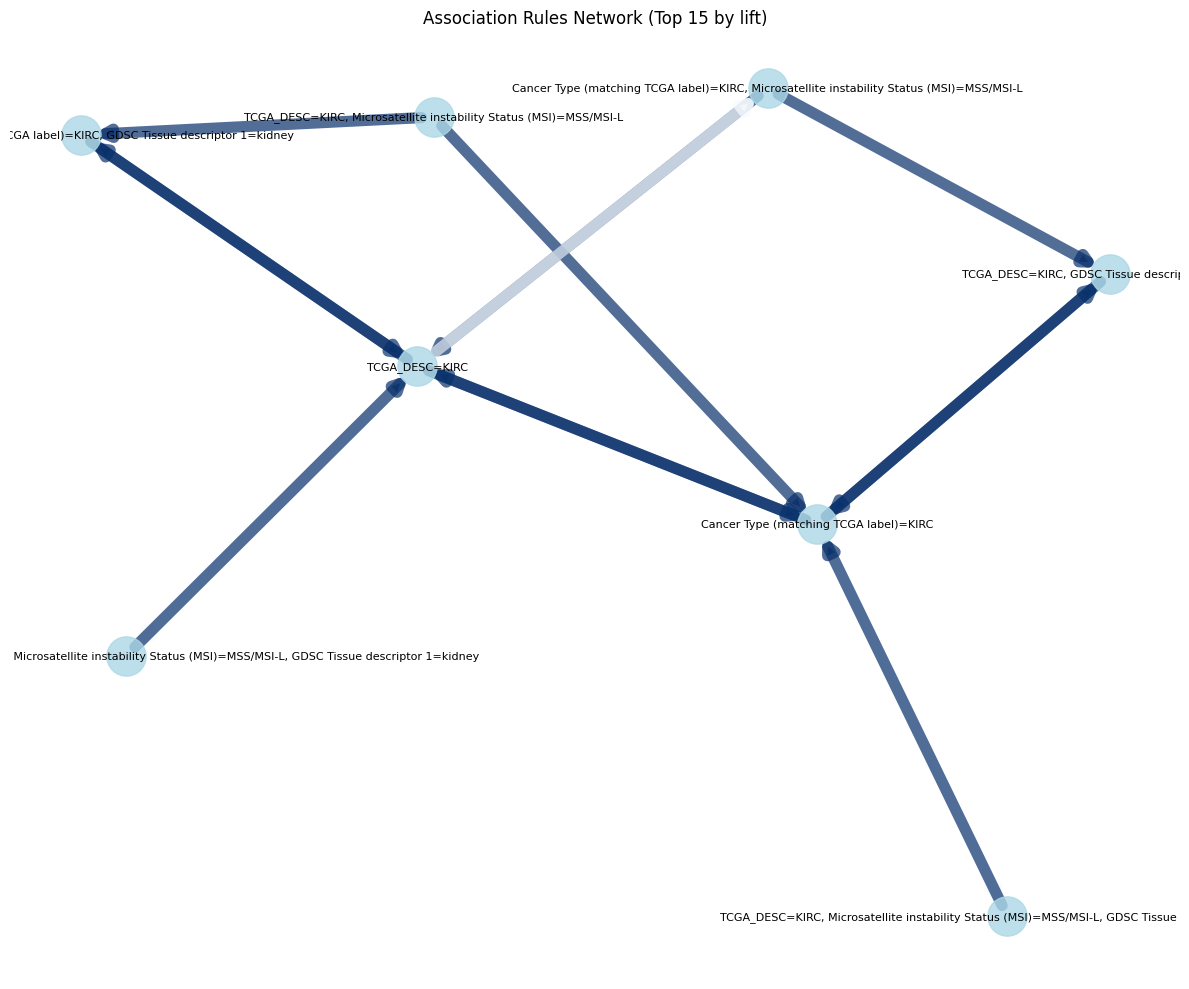

In [24]:
if len(rules) > 0:
    plot_network(rules, metric='lift', n_rules=min(15, len(rules)))

In [25]:
if len(rules) > 0:
    print("\nSummary of Association Rules:")
    print(f"Number of frequent itemsets: {len(frequent_itemsets)}")
    print(f"Number of rules: {len(rules)}")
    print(f"Min support threshold: {min_support}")
    print(f"Min confidence threshold: {min_confidence}")
    print(f"Support range: {rules['support'].min()} - {rules['support'].max()}")
    print(f"Confidence range: {rules['confidence'].min()} - {rules['confidence'].max()}")
    print(f"Lift range: {rules['lift'].min()} - {rules['lift'].max()}")
else:
    print("\nSummary:")
    print(f"Number of frequent itemsets: {len(frequent_itemsets)}")
    print("No rules were generated. Try adjusting the thresholds.")


Summary of Association Rules:
Number of frequent itemsets: 1202
Number of rules: 2774
Min support threshold: 0.03
Min confidence threshold: 0.6
Support range: 0.03 - 0.315
Confidence range: 0.6 - 1.0
Lift range: 1.0000451797060883 - 32.67973856209151


In [26]:
def plot_rules_heatmap(rules, top_n=20, metric='lift'):
    """
    Create a heatmap visualization of association rules
    
    Parameters:
    -----------
    rules : pandas.DataFrame
        DataFrame containing the association rules
    top_n : int
        Number of top rules to display
    metric : str
        Metric to use for sorting ('lift', 'confidence', or 'support')
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Select top N rules based on the metric
    top_rules = rules.sort_values(metric, ascending=False).head(top_n)
    
    # Create lists of antecedents and consequents
    antecedents = [', '.join(list(x)) for x in top_rules['antecedents']]
    consequents = [', '.join(list(x)) for x in top_rules['consequents']]
    
    # Create a pivot table for the heatmap
    # First, prepare the data
    heatmap_data = []
    for i, row in top_rules.iterrows():
        ant = ', '.join(list(row['antecedents']))
        con = ', '.join(list(row['consequents']))
        heatmap_data.append({
            'antecedent': ant,
            'consequent': con,
            'lift': row['lift'],
            'confidence': row['confidence'],
            'support': row['support']
        })
    
    # Convert to DataFrame
    hm_df = pd.DataFrame(heatmap_data)
    
    # Create a matrix for the heatmap
    matrix = pd.pivot_table(
        hm_df, 
        values=metric, 
        index='antecedent',
        columns='consequent'
    )
    
    # Fill NaN values with 0
    matrix = matrix.fillna(0)
    
    # Create a mask for zero values
    mask = matrix == 0
    
    # Create the heatmap
    plt.figure(figsize=(14, 12))
    cmap = sns.color_palette("YlOrRd", as_cmap=True)
    
    ax = sns.heatmap(
        matrix, 
        annot=True, 
        fmt='.2f' if metric != 'support' else '.3f',
        mask=mask,
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={'label': metric.capitalize()}
    )
    
    plt.title(f'Top {top_n} Association Rules by {metric.capitalize()}')
    plt.ylabel('Antecedent (If)')
    plt.xlabel('Consequent (Then)')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    return plt

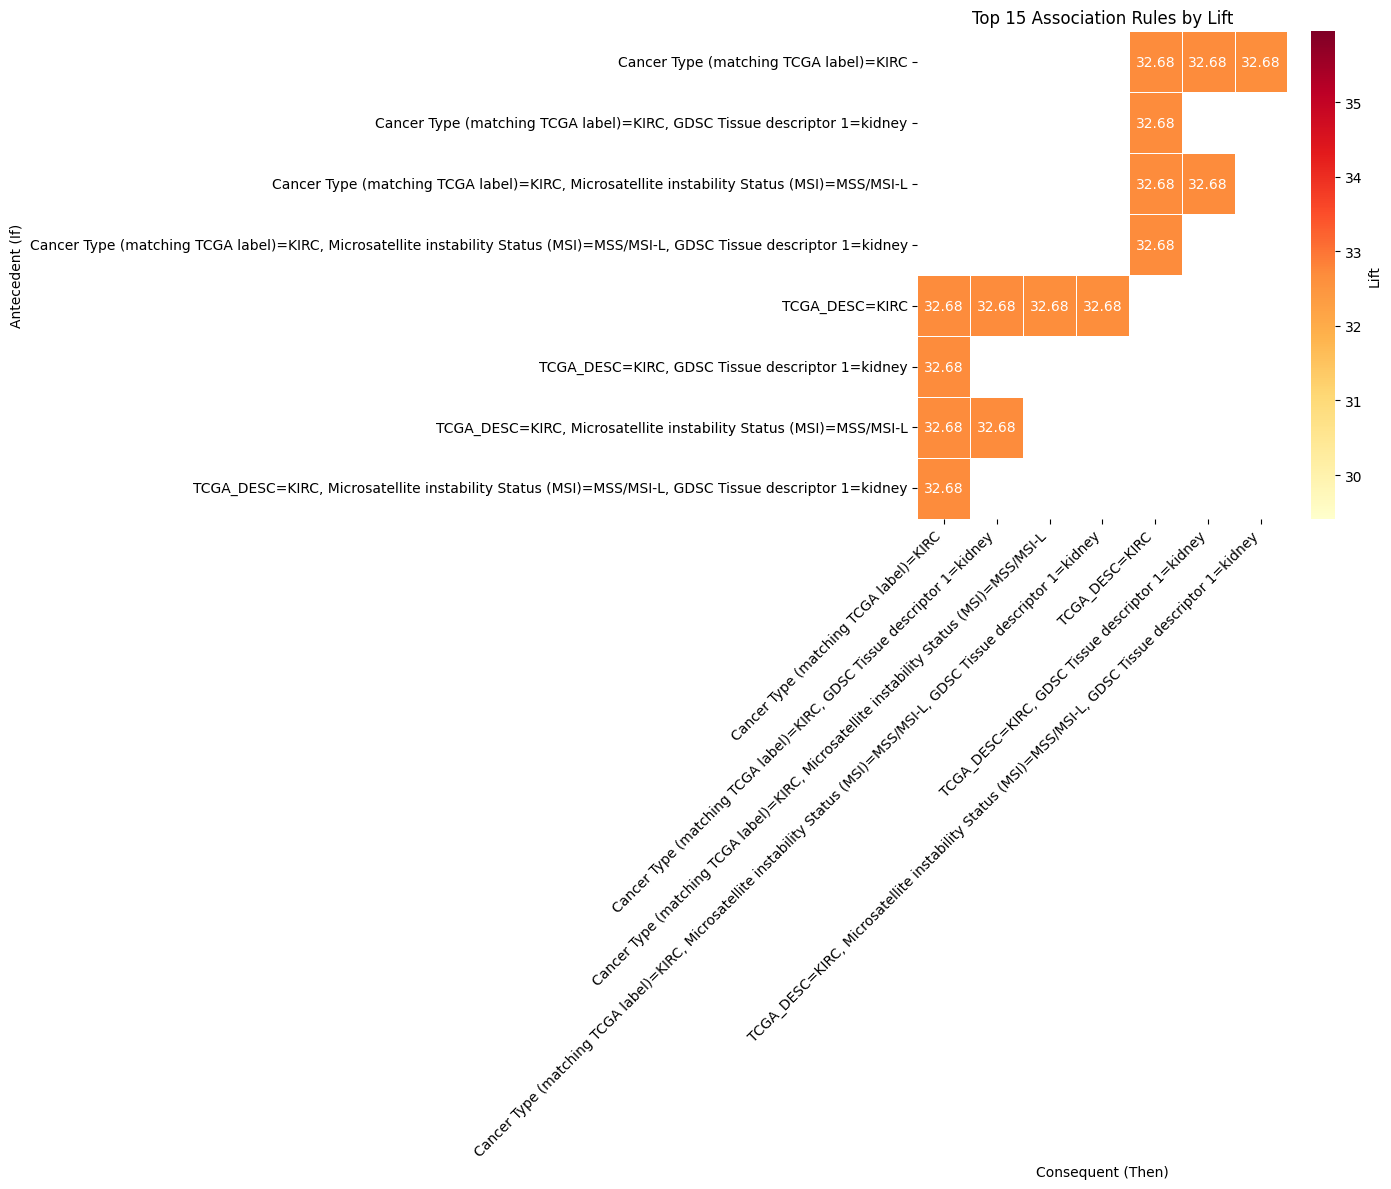

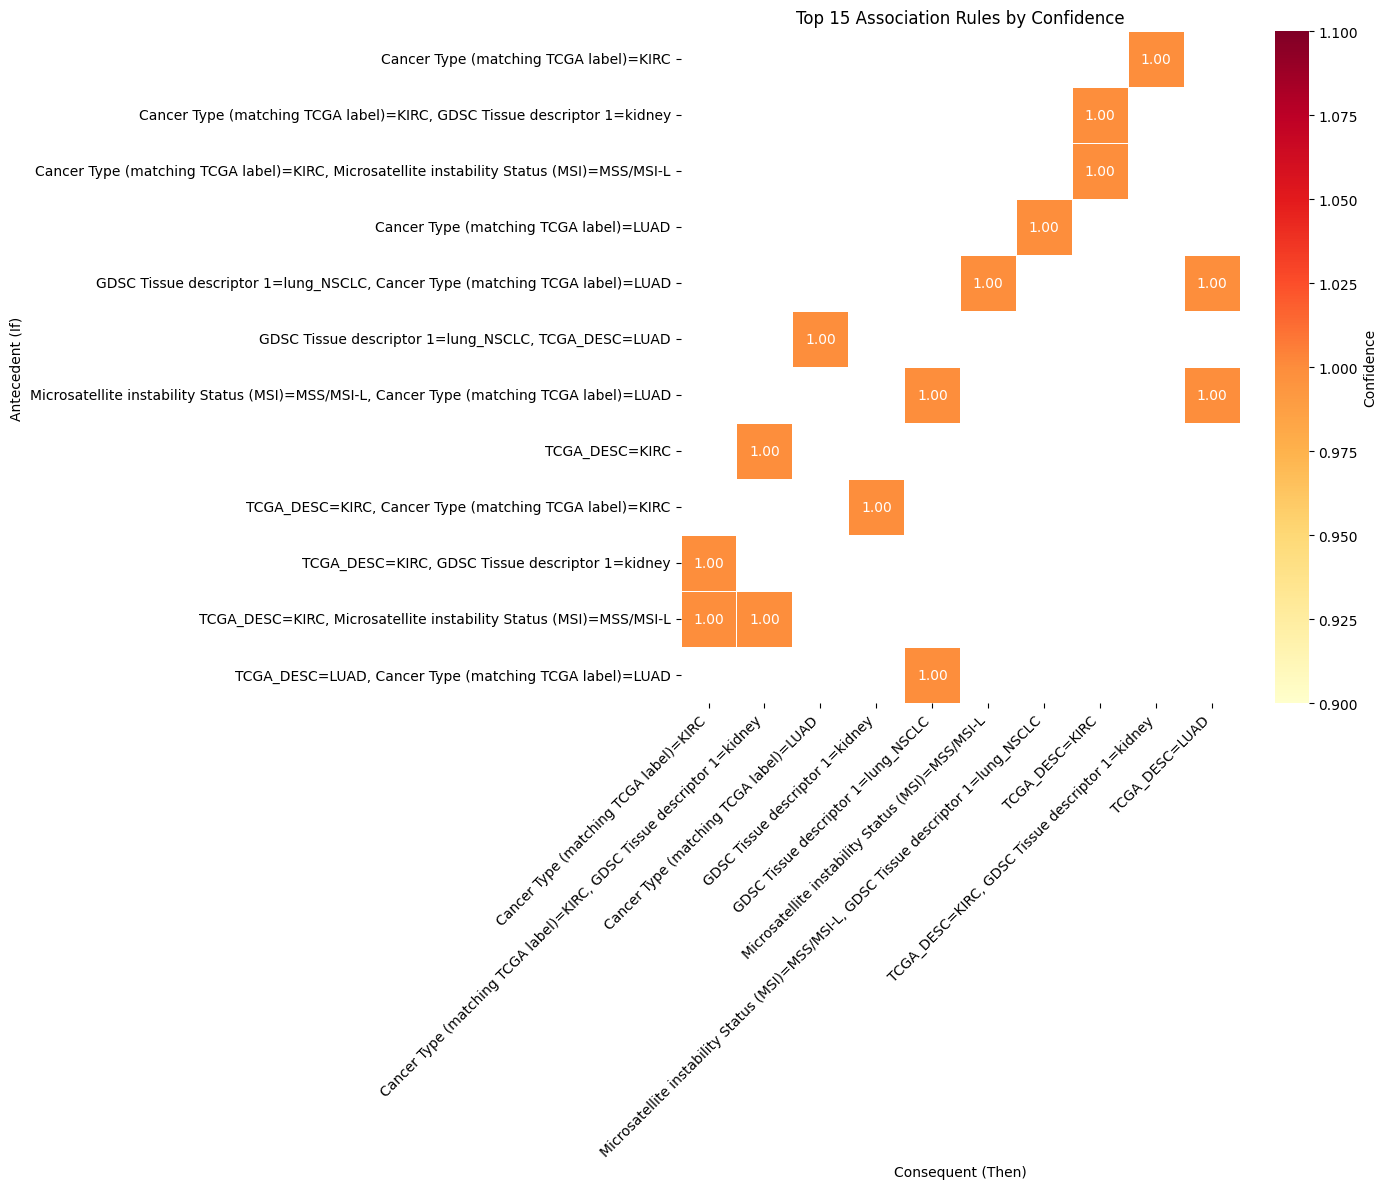

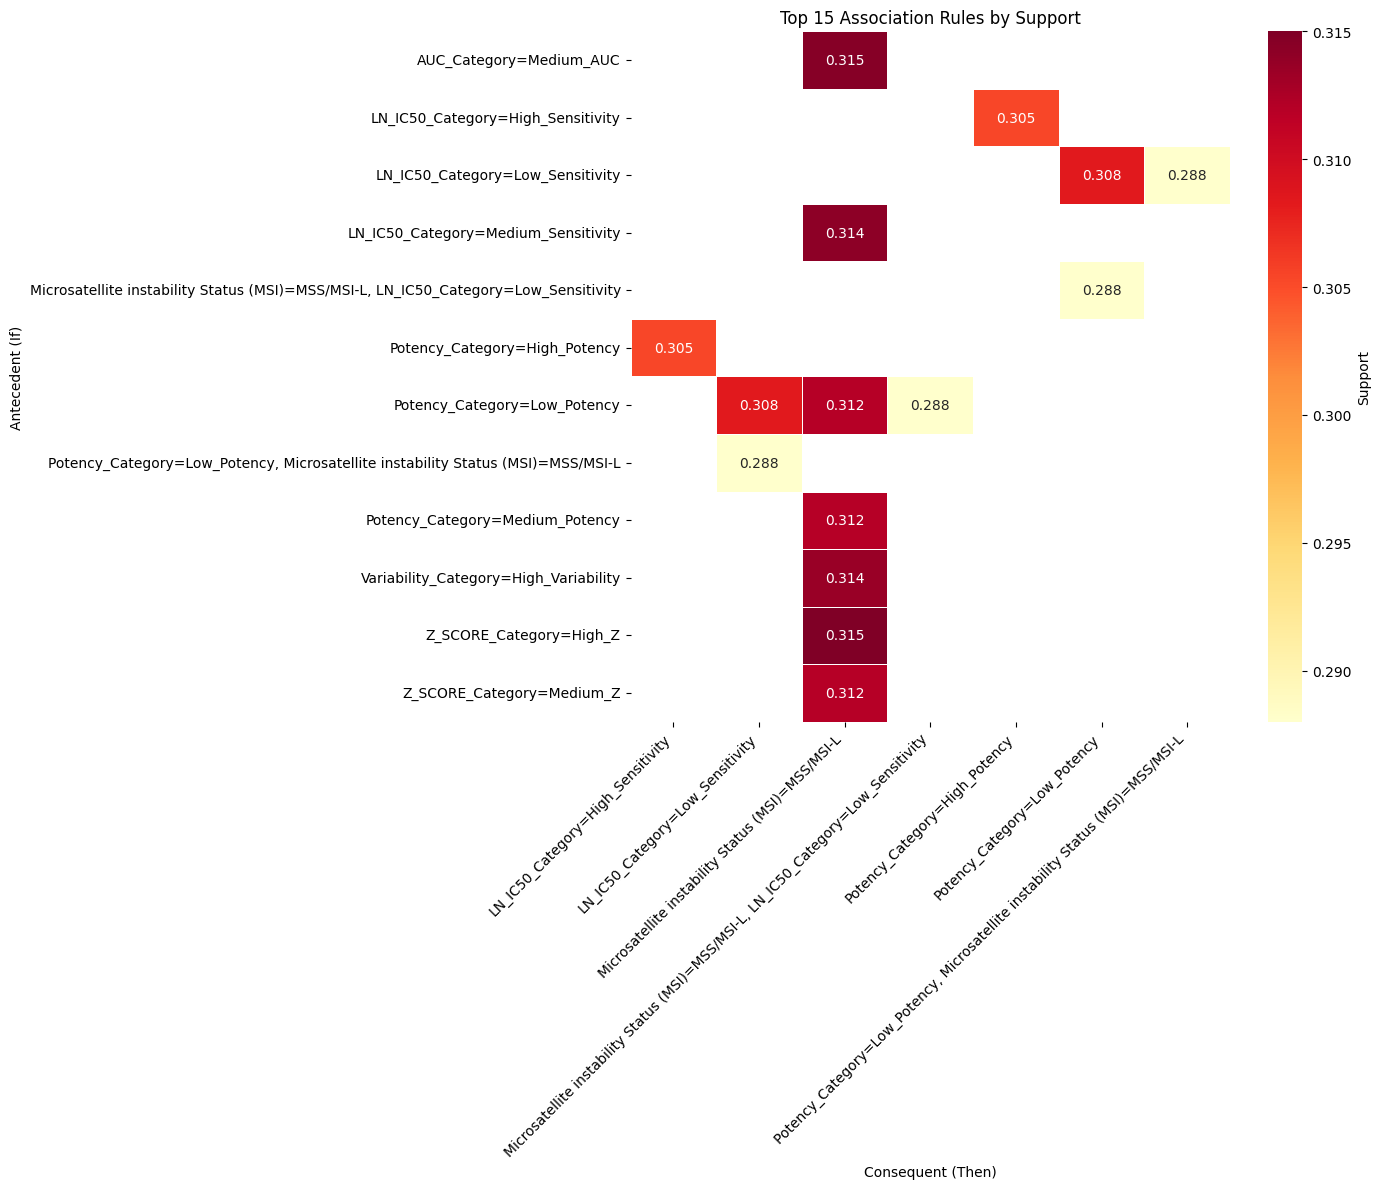

In [27]:
# Example usage
plot_rules_heatmap(rules, top_n=15, metric='lift')
plt.savefig('/kaggle/working/association_rules_heatmap_lift.png', dpi=300, bbox_inches='tight')
plt.show()

# Create heatmaps for different metrics
plot_rules_heatmap(rules, top_n=15, metric='confidence')
plt.savefig('/kaggle/working/association_rules_heatmap_confidence.png', dpi=300, bbox_inches='tight')
plt.show()

plot_rules_heatmap(rules, top_n=15, metric='support')
plt.savefig('/kaggle/working/association_rules_heatmap_support.png', dpi=300, bbox_inches='tight')
plt.show()